In [388]:
# !pip install gnss_lib_py|

In [389]:
import numpy as np
import gnss_lib_py as glp
import matplotlib.pyplot as plt
from datetime import datetime, timezone
import pandas as pd

https://drive.google.com/drive/folders/17vNrS_-Kq0msv2r9VHDkry3aEAxUcdAS

### Pseudorange computation

In [390]:
def compute_pseudoranges(raw_data):
    nanosecs_in_week = 604800e9
    speed_of_light = 299792458
    week_no = np.floor(-raw_data['FullBiasNanos']/nanosecs_in_week)
    corrected_rx_time = raw_data['TimeNanos'] + raw_data['TimeOffsetNanos']
    adjusted_rx_bias = raw_data['FullBiasNanos'] + raw_data['BiasNanos']
    rx_time_gps_frame = corrected_rx_time - adjusted_rx_bias
    rx_time_week_frame = rx_time_gps_frame - week_no * nanosecs_in_week
    rho_nanosecs = rx_time_week_frame - raw_data['ReceivedSvTimeNanos']
    rho_m = rho_nanosecs * speed_of_light/1e9
    return rho_m

In [391]:
rover_path = './Oval/RoundLoop1_gnss_log_2024_11_17_16_52_31.txt'
base_path = './Oval/RoundLoop1_BaseStation_gnss_log_2024_11_17_16_52_30.txt'

In [ ]:
rover_data = glp.AndroidRawGnss(input_path=rover_path,
                              filter_measurements=True,
                              measurement_filters={"sv_time_uncertainty" : 500.},
                              verbose=True)
rover_data['TimeNanos'] = rover_data['TimeNanos'] - 604800e9
offset_ms_rover = 50
offset_ms_base = 50

base_data = glp.AndroidRawGnss(input_path=base_path,
                              filter_measurements=True,
                              measurement_filters={"sv_time_uncertainty" : 500.},
                              verbose=True)


offset_rover_data = rover_data.copy()
offset_base_data = base_data.copy()
offset_rover_data["gps_millis"] = rover_data["gps_millis"] + offset_ms_rover
offset_base_data["gps_millis"] = base_data["gps_millis"] + offset_ms_base

sv_time_uncertainty removed 1
sv_time_uncertainty removed 1


In [393]:
rover_data_gps_only = offset_rover_data.where('gnss_id', ('gps'), 'eq')
base_data_gps_only = offset_base_data.where('gnss_id', ('gps'), 'eq')

In [394]:
rover_rho = compute_pseudoranges(rover_data_gps_only)

In [395]:
def interpolate_base_values(rover_data_gps_millis, base_data_for_sat):
    '''
    rover_data_gps_millis: This is the GPS millis time for a single measurement in the rover data
    base_data_for_sat: This are all the measurements in the base data for a single satellite (i.e. the
                        sv_id and gnss_id have already been matched).

    Returns:
    Interpolated data: All the data columns in the base data interpolated to get values for the exact gps millis used
                       in the rover data.
    success: If interpolation was successful. If not, flag to indicate that we should throw out that data point.
    '''
    GPS_MILLIS_COL = -3
    upper_index = np.searchsorted(base_data_for_sat['gps_millis'], rover_data_gps_millis)
    base_data_array_ver = base_data_for_sat.array
    row_lower = base_data_array_ver[:, upper_index-1]
    row_higher = base_data_array_ver[:, upper_index]
    interpolated_data_arr = row_lower + (rover_data_gps_millis - row_lower[GPS_MILLIS_COL])/(row_higher[GPS_MILLIS_COL] - row_lower[GPS_MILLIS_COL]) * (row_higher - row_lower)
    interpolated_data_pd = pd.DataFrame(columns = base_data_for_sat.rows)
    interpolated_data_pd.loc[0] = interpolated_data_arr
    interpolated_data = glp.NavData()
    interpolated_data.from_pandas_df(interpolated_data_pd)
    # There might be more edge cases
    if (upper_index - 1) < 0:
        success = False
    else:
        success = True

    return interpolated_data, success

In [396]:
def compute_and_match_pr(rover_data, base_data):
    base_rho = []
    base_matched_data = []
    # time_tolerance = 5000
    for i in range(len(rover_data_gps_only)):
        sv_id = rover_data['sv_id']
        gnss_id = rover_data['gnss_id']
        gps_millis = rover_data['gps_millis']
        print(f'Rover data uses sv id of {sv_id[i]}, gnss id of {gnss_id[i]}, millis of {gps_millis[i]}')
        a = base_data.where("sv_id", sv_id[i], "eq")
        b = a.where("gnss_id", gnss_id[i], "eq")
        # c = b.where("gps_millis", gps_millis[i]-time_tolerance, "geq").where("gps_millis", gps_millis[i]+time_tolerance, "leq")
        c, success = interpolate_base_values(gps_millis[i], b)
        
        if not success:
            print('WARNING: UNSUCUESSFUL INTERPOLATION')
        rho_vals = compute_pseudoranges(c)
        # try: 
        #     if len(rho_vals) > 0:
        #         rho_m = rho_vals[0]
        #         c_val = c[:, 0]
        #     else:
        #         rho_m = np.nan
        #         c_val = np.nan
        # except:
        #     rho_m = rho_vals
        #     c_val = c.array[:, 0]
        # base_rho.append(rho_m)
        base_rho.append(rho_vals)
        # base_matched_data.append(c_val)
        base_matched_data.append(c.array.squeeze())
    return base_matched_data, base_rho
matched_base_data, base_rho = compute_and_match_pr(rover_data_gps_only, base_data_gps_only)
base_rho = np.array(base_rho)

Rover data uses sv id of 2, gnss id of gps, millis of 1415926367389.0
Rover data uses sv id of 7, gnss id of gps, millis of 1415926367389.0
Rover data uses sv id of 13, gnss id of gps, millis of 1415926367389.0
Rover data uses sv id of 14, gnss id of gps, millis of 1415926367389.0
Rover data uses sv id of 15, gnss id of gps, millis of 1415926367389.0
Rover data uses sv id of 17, gnss id of gps, millis of 1415926367389.0
Rover data uses sv id of 19, gnss id of gps, millis of 1415926367389.0
Rover data uses sv id of 21, gnss id of gps, millis of 1415926367389.0
Rover data uses sv id of 22, gnss id of gps, millis of 1415926367389.0
Rover data uses sv id of 30, gnss id of gps, millis of 1415926367389.0
Rover data uses sv id of 2, gnss id of gps, millis of 1415926368389.0
Rover data uses sv id of 7, gnss id of gps, millis of 1415926368389.0
Rover data uses sv id of 13, gnss id of gps, millis of 1415926368389.0
Rover data uses sv id of 14, gnss id of gps, millis of 1415926368389.0
Rover data

### Verifying that the rover is matched well to base measurements

(20000000.0, 25000000.0)

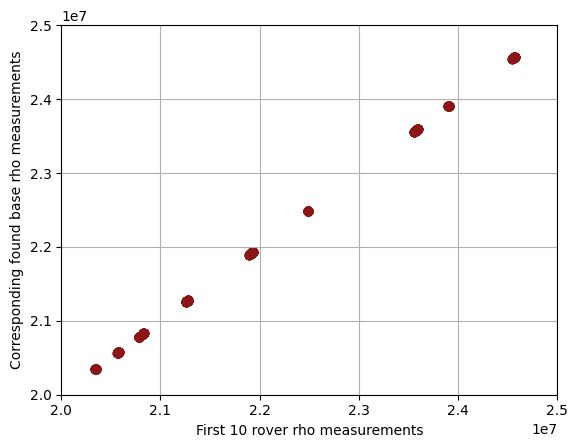

In [397]:
plt.scatter(rover_rho, base_rho)
plt.grid()
plt.xlabel('First 10 rover rho measurements')
plt.ylabel('Corresponding found base rho measurements')
plt.xlim(2e7, 2.5e7)
plt.ylim(2e7, 2.5e7)

In [398]:
timestamps = rover_data_gps_only['gps_millis']
base_timestamps = base_data_gps_only['gps_millis']
satellites = rover_data_gps_only['sv_id']
print(f'number of unique timesteps {len(np.unique(timestamps))}')

number of unique timesteps 75


### Calculate true ranges

In [399]:
BASE_STATION_LOCATION_1 = np.array([37.429711,-122.169381,25]).reshape(3, 1)
BASE_STATION_LOCATION_2 = np.array([37.4290631,-122.1723136,25]).reshape(3, 1) # multipath test

DURAND = np.array([[37.426906], [-122.173278], [21.010]]) 

In [400]:
gps_millis_column = -3
sv_id_column = 11
gnss_id_column = -13

In [401]:
matched_base_data_clean = np.zeros((len(matched_base_data),len(matched_base_data[0])))
for i in range(len(matched_base_data)):
    matched_base_data_clean[i, :] = matched_base_data[i]
    matched_base_data_clean[i, gnss_id_column] = 100.0

In [402]:
## Load the RinexNav data for that day
rinex_nav_paths = glp.load_ephemeris(
    "rinex_nav",
    np.array(np.nanmin(matched_base_data_clean[:, gps_millis_column]),np.nanmax(matched_base_data_clean[:, gps_millis_column])),
    verbose=True,
)
rinex_nav = glp.RinexNav(rinex_nav_paths, verbose=True)

ephemeris dates needed: [datetime.date(2024, 11, 17), datetime.date(2024, 11, 18)]
using previously downloaded file:
 /home/gigavoltflash/stanford_classes/AA_272/dgnss_aa272/data/ephemeris/rinex/nav/BRDM00DLR_S_20243220000_01D_MN.rnx
using previously downloaded file:
 /home/gigavoltflash/stanford_classes/AA_272/dgnss_aa272/data/ephemeris/rinex/nav/BRDM00DLR_S_20243230000_01D_MN.rnx
using previously downloaded file:
 /home/gigavoltflash/stanford_classes/AA_272/dgnss_aa272/data/ephemeris/rinex/nav/BRDM00DLR_S_20243220000_01D_MN.rnx
using previously downloaded file:
 /home/gigavoltflash/stanford_classes/AA_272/dgnss_aa272/data/ephemeris/rinex/nav/BRDM00DLR_S_20243230000_01D_MN.rnx


In [403]:
GNSS_ID_FLOAT = 100.0
def find_sv_pos(rinex, gnss_data_array):
    """ finding sv position with ephemeris data FOR DURAND receiver"""
    sv_id = gnss_data_array[:, sv_id_column]
    gps_millis = gnss_data_array[:, gps_millis_column]
    n = len(sv_id)
    position_info = np.zeros((n, 3))
    bias_info = np.zeros(n)
    for i in range(n):
        print(i)
        sv_at_millis = glp.find_sv_states(gps_millis[i], rinex)
        cropped_sv_at_millis = sv_at_millis.where('sv_id', sv_id[i], 'eq')
        gnss_id_at_millis = cropped_sv_at_millis.where('gnss_id', ('gps'), 'eq')
        # TODO: JANK PLS FIX AND DO SOMETHING SMARTER
        position_info[i, 0] = np.mean(gnss_id_at_millis['x_sv_m'])
        position_info[i, 1] = np.mean(gnss_id_at_millis['y_sv_m'])
        position_info[i, 2] = np.mean(gnss_id_at_millis['z_sv_m'])
        bias_info[i] = np.mean(gnss_id_at_millis['b_sv_m'])
    return position_info, bias_info

# FOR DURAND DATA
# def get_measured_pseudorange(df,sv_id):
#     """ get measured pseudorange of specific sv for durand receiver"""
#     filtered_df = df[df.iloc[:,4] == str(sv_id)]
#     return filtered_df.iloc[:,14]

def distance_to_groundtruth(sv_pos, ground_truth):
    """ calculate ground truth distance from SV to Durand receiver"""
    gt_ecef = glp.geodetic_to_ecef(ground_truth)
    distance = np.linalg.norm(sv_pos[:, :, None] - gt_ecef[None, :, :], axis=1)
    return distance

def correction(true_range, base_pseudorange, rover_pseudorange):
    """ true_range: ground truth distance from distance_to_groundtruth function
    base_pseudorange: pseudorange for base station
    pseudorange: pseudorange for phone """
    e = true_range - base_pseudorange
    adjusted_pseudorange = rover_pseudorange + e
    return adjusted_pseudorange



# def get_pseudorange(raw_data, sv_id):
#     """ get measure pseudorange of the rover with specified sv_id"""
#     cropped_data = raw_data.where("sv_id", sv_id, "eq")
#     pseudorange = compute_pseudoranges(cropped_data)
#     return pseudorange

In [404]:
sv_pos, sv_bias = find_sv_pos(rinex_nav, matched_base_data_clean)
# sv_pos_base_data_gps_only, sv_bias_base_data_gps_only = find_sv_pos(rinex_nav, base_data_gps_only.array.T)
# sv_pos = find_sv_pos(rover_ephemeris, 6)
# true_ranges = distance_to_groundtruth()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [405]:
rover_rho_corrected = rover_rho + sv_bias
base_rho_corrected = base_rho + sv_bias

### Actual dGNSS shit

In [406]:
true_range = distance_to_groundtruth(sv_pos, BASE_STATION_LOCATION_1).flatten()
corrected_pseudorange = correction(true_range, base_rho_corrected, rover_rho_corrected)

In [407]:
sv_pos

array([[ 13802754.00121232, -15355804.72694224,  16972773.43061484],
       [  6297445.65136157, -25494750.58499839,  -1052431.07285987],
       [-20448270.93829893, -10574192.97100789,  13220687.15072866],
       ...,
       [ 15208958.89816206,  -8125589.16240464,  20280820.10476758],
       [-12023040.23620034, -12081951.79162954,  20688744.91907789],
       [ -1683672.20669746, -24803022.16460862,   9113878.13668457]])

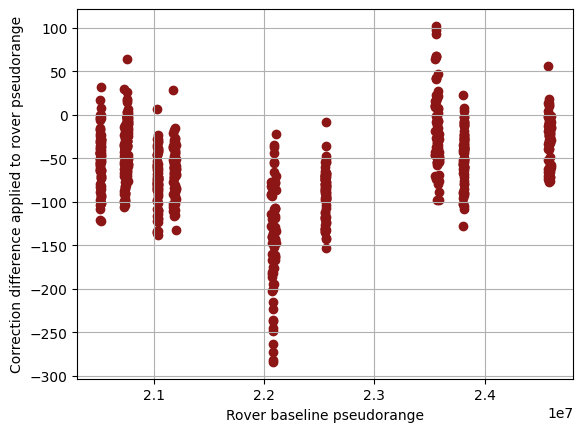

In [408]:
plt.scatter(rover_rho_corrected, corrected_pseudorange - rover_rho_corrected)
plt.xlabel('Rover baseline pseudorange')
plt.ylabel('Correction difference applied to rover pseudorange')
plt.grid()

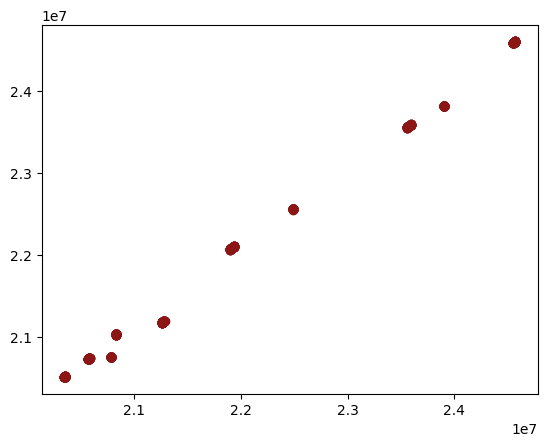

In [409]:
plt.scatter(rover_rho, corrected_pseudorange)

### Newton Raphson to solve for position

In [410]:
def newton_raphson(x0, bu_0, max_iterations, dataset):
    """
    Function description: perform newton raphson to compute position of observer based on available satellite
    data, stop function when we have updates in delta_x, delta_bu that are less than a centimeter,
    or hit maximum number of iterations

    Inputs:
    1) x_0: initial guess for position
    2) bu_0: initial guess for clock bias
    3) max_iterations: maximum number of iterations until covergence
    4) dataset_name: name of file to read in

    return: 
    1) optimized position
    2) optimized clock bias
    3) number of iterations until covergence
    """
    x_est = x0
    b_est = bu_0


    for i in range(max_iterations):

        # Get Geometry Matrix and deltas for rho
        geometry_matrix = []
        delta_rho = []
        for index, sat in dataset.iterrows():
            geometry_matrix.append(get_geometry_row(x_est, sat['x_sv_m'], sat['y_sv_m'], sat['z_sv_m']))
            delta_rho.append(sat['corr_pr_m'] - get_theoretical_pseudoranges(x_est, b_est, sat['x_sv_m'], sat['y_sv_m'], sat['z_sv_m']))

        # Convert into matricies to make it easier to use numpy functions
        geometry_matrix = np.array(geometry_matrix)
        delta_rho = np.array(delta_rho)

        # Update the deltas
        delta_x, delta_bu = newton_raphson_step(geometry_matrix, delta_rho)
        x_est = np.add(x_est, delta_x)
        b_est = b_est + delta_bu
    
        if True: #i%10 == 0:
            print("round: ",i+1)
            print("x_est: ", x_est)
            print("b_est: ", b_est)

        if delta_x[0] < 0.01 and delta_x[1] < 0.01 and delta_x[2] < 0.01 and delta_bu < 0.01:
            break
    
    
    print("round: ",i+1)
    print("FINAL - x_est: ", x_est)
    print("FINAL - b_est: ", b_est)
    return x_est


def get_geometry_row(x_est, x_sv_m, y_sv_m, z_sv_m):
    """
    Function description: Compute each row for the geometry matrix given a satellite position and
    current guess for position estimate

    Inputs:
    1) x_est: current guess for current position estimate 
    2) x_sv_m: a set for satellite position x
    3) y_sv_m: a set for satellite position y
    4) z_sv_m: a set for satellite position z


    return: 
    1) Geometry Matrix G (first 3 columns unit vector)
    """

    x = x_sv_m - x_est[0]
    y = y_sv_m - x_est[1]
    z = z_sv_m - x_est[2]

    magnitude = np.sqrt((x)**2 + (y)**2 + (z)**2)

    return ([-x/magnitude, -y/magnitude, -z/magnitude, 1])



def get_theoretical_pseudoranges(x_est, b_est, x_sv_m, y_sv_m, z_sv_m):
    """
    Function description: Compute each row for the geometry matrix given a satellite position and
    current guess for position estimate

    Inputs:
    1) x_est: current position estimate 
    2) b_est: current clock bias estimate 
    3) x_sv_m: a set for satellite position x
    4) y_sv_m: a set for satellite position y
    5) z_sv_m: a set for satellite position z

    return: 
    1) Theoretical pseudorange measurement vector
    """


    x = x_sv_m - x_est[0]
    y = y_sv_m - x_est[1]
    z = z_sv_m - x_est[2]

    magnitude = np.sqrt((x)**2 + (y)**2 + (z)**2)
    b_k = 0 # assume its zero for all satellites, already corrrected for in data

    return magnitude + b_est - b_k

def newton_raphson_step(G,delta_rho):
    """
    Function description: Take one step of newton-raphson optimization, compute update of 
    delta_x and delta_bu

    Input:
    1) G: geometry matrix
    2) delta_rho: difference of theoretical and measured pseudoranges 

    return:
    1) delta_x
    2) delta_bu
    """
    G_t = G.transpose()
    deltas = np.matmul(np.matmul(np.linalg.inv(np.matmul(G_t, G)),G_t),delta_rho)

    delta_x = deltas[0:3]
    delta_bu = deltas[3]

    return delta_x, delta_bu

In [411]:
unique_timestamps = np.unique(timestamps)

pos_ls = []
# batch pr with same millis
for i in range(len(unique_timestamps)):
    mask = timestamps == unique_timestamps[i]
    pr = corrected_pseudorange[mask]
    x = sv_pos[mask, 0]
    y = sv_pos[mask, 1]
    z = sv_pos[mask, 2]

    # Create DataFrame using the arrays
    df = pd.DataFrame({
        'x_sv_m': x,
        'y_sv_m': y,
        'z_sv_m': z,
        'corr_pr_m': pr
    })

    df_cleaned = df.dropna()
    pos = newton_raphson([0,0,0],0,30,df_cleaned)

    print("Lat/Long Version: ",glp.ecef_to_geodetic(pos))

    pos_ls.append(glp.ecef_to_geodetic(pos))

pos_array = np.array(pos_ls)
dgnss = glp.NavData()
dgnss['lat_dgnss_deg'] = pos_array[:,:,0]
dgnss['lon_rx_gnss_deg'] = pos_array[:,:,1]

    

round:  1
x_est:  [-3190248.68483305 -5150258.7389064   4662424.43917666]
b_est:  1319721.2448818116
round:  2
x_est:  [-2713026.04155717 -4320263.79041069  3883488.33007731]
b_est:  45362.426959568635
round:  3
x_est:  [-2700013.2475547  -4292671.95880251  3855425.64076829]
b_est:  67.85516845234815
round:  4
x_est:  [-2700000.91522505 -4292640.69939837  3855392.07529892]
b_est:  17.228490586740733
round:  5
x_est:  [-2700000.91521206 -4292640.69935944  3855392.07525522]
b_est:  17.22842559712904
round:  5
FINAL - x_est:  [-2700000.91521206 -4292640.69935944  3855392.07525522]
FINAL - b_est:  17.22842559712904
Lat/Long Version:  [[  37.42974183 -122.16922257   28.32542956]]
round:  1
x_est:  [-3190234.93818404 -5150234.39996445  4662392.73637732]
b_est:  1319625.0169910244
round:  2
x_est:  [-2713033.03419791 -4320268.89812686  3883496.77728855]
b_est:  45308.801538202446
round:  3
x_est:  [-2700022.55088219 -4292680.49282992  3855438.92090784]
b_est:  20.185504463428515
round:  4
x_e

round:  5
x_est:  [-2700003.5992748  -4292639.02688412  3855386.31799681]
b_est:  14.53823654366407
round:  5
FINAL - x_est:  [-2700003.5992748  -4292639.02688412  3855386.31799681]
FINAL - b_est:  14.53823654366407
Lat/Long Version:  [[  37.42970057 -122.1692583    24.83682988]]
round:  1
x_est:  [-3189853.40129722 -5149683.958251    4661684.21945756]
b_est:  1318880.4246330897
round:  2
x_est:  [-2712989.64871044 -4320198.86657596  3883431.11196122]
b_est:  45276.29163276078
round:  3
x_est:  [-2700013.07282284 -4292662.29953538  3855444.76053153]
b_est:  78.37643553224916
round:  4
x_est:  [-2700000.82162334 -4292631.18912837  3855411.39487522]
b_est:  28.017128039292388
round:  5
x_est:  [-2700000.82161134 -4292631.18908789  3855411.39483771]
b_est:  28.017065264691777
round:  5
FINAL - x_est:  [-2700000.82161134 -4292631.18908789  3855411.39483771]
FINAL - b_est:  28.017065264691777
Lat/Long Version:  [[  37.42992442 -122.16927889   33.63540715]]
round:  1
x_est:  [-3189836.268597

In [412]:
raw_ls = []
# batch pr with same millis
for i in range(len(unique_timestamps)):
    mask = timestamps == unique_timestamps[i]
    pr = rover_rho_corrected[mask]
    x = sv_pos[mask, 0]
    y = sv_pos[mask, 1]
    z = sv_pos[mask, 2]

    # Create DataFrame using the arrays
    df = pd.DataFrame({
        'x_sv_m': x,
        'y_sv_m': y,
        'z_sv_m': z,
        'corr_pr_m': pr
    })

    df_cleaned = df.dropna()
    pos = newton_raphson([0,0,0],0,30,df_cleaned)

    print("Lat/Long Version: ",glp.ecef_to_geodetic(pos))

    raw_ls.append(glp.ecef_to_geodetic(pos))

raw_array = np.array(raw_ls)
rover = glp.NavData()
rover['lat_rover_deg'] = raw_array[:,:,0]
rover['lon_rover_deg'] = raw_array[:,:,1]

round:  1
x_est:  [-3190224.011602   -5150282.36924704  4662459.56497695]
b_est:  1319768.939096904
round:  2
x_est:  [-2713003.38782419 -4320280.35179702  3883517.44025858]
b_est:  45401.85670397035
round:  3
x_est:  [-2699990.31349686 -4292687.94730093  3855453.72932452]
b_est:  106.29677525583247
round:  4
x_est:  [-2699977.97333419 -4292656.68398896  3855420.14573505]
b_est:  55.65846972513603
round:  5
x_est:  [-2699977.97331237 -4292656.6839483   3855420.14567532]
b_est:  55.658396018625176
round:  5
FINAL - x_est:  [-2699977.97331237 -4292656.6839483   3855420.14567532]
FINAL - b_est:  55.658396018625176
Lat/Long Version:  [[  37.42993547 -122.16890701   46.43131801]]
round:  1
x_est:  [-3190205.92660167 -5150252.3149544   4662416.65229385]
b_est:  1319728.1066637994
round:  2
x_est:  [-2713007.29749746 -4320281.64649711  3883517.50953112]
b_est:  45407.27041096846
round:  3
x_est:  [-2699996.59699548 -4292692.8256775   3855458.79144708]
b_est:  117.93037735758116
round:  4
x_es

In [413]:
base_ls = []
# batch pr with same millis
for i in range(len(unique_timestamps)):
    mask = timestamps == unique_timestamps[i]
    pr = base_rho_corrected[mask]
    x = sv_pos[mask, 0]
    y = sv_pos[mask, 1]
    z = sv_pos[mask, 2]

    # Create DataFrame using the arrays
    df = pd.DataFrame({
        'x_sv_m': x,
        'y_sv_m': y,
        'z_sv_m': z,
        'corr_pr_m': pr
    })

    df_cleaned = df.dropna()
    pos = newton_raphson([0,0,0],0,30,df_cleaned)

    print("Lat/Long Version: ",glp.ecef_to_geodetic(pos))

    base_ls.append(glp.ecef_to_geodetic(pos))

base_array = np.array(base_ls)
base = glp.NavData()
base['lat_base_deg'] = base_array[:,:,0]
base['lon_base_deg'] = base_array[:,:,1]

round:  1
x_est:  [-3190236.51057991 -5150270.9055256   4662452.25880778]
b_est:  1319748.4020067619
round:  2
x_est:  [-2713014.93068706 -4320272.26331007  3883512.56795233]
b_est:  45384.389323617565
round:  3
x_est:  [-2700001.88427665 -4292680.00810574  3855448.99214351]
b_est:  89.06972533935914


round:  4
x_est:  [-2699989.54382063 -4292648.74312179  3855415.40692236]
b_est:  38.4300670600732
round:  5
x_est:  [-2699989.5437983  -4292648.74307904  3855415.40686028]
b_est:  38.42999128306579
round:  5
FINAL - x_est:  [-2699989.5437983  -4292648.74307904  3855415.40686028]
FINAL - b_est:  38.42999128306579
Lat/Long Version:  [[  37.42990464 -122.16906543   43.10525531]]
round:  1
x_est:  [-3190205.8756233  -5150227.78033115  4662390.32995286]
b_est:  1319747.127803171
round:  2
x_est:  [-2713009.43181211 -4320264.76801208  3883499.10933167]
b_est:  45436.986478614854
round:  3
x_est:  [-2699998.85906481 -4292676.34241431  3855440.7611944 ]
b_est:  148.35529544528254
round:  4
x_est:  [-2699986.52406535 -4292645.08825405  3855407.18866229]
b_est:  97.73385622652036
round:  5
x_est:  [-2699986.524043   -4292645.08821172  3855407.18859951]
b_est:  97.73378038766951
round:  5
FINAL - x_est:  [-2699986.524043   -4292645.08821172  3855407.18859951]
FINAL - b_est:  97.73378038766951
La

In [414]:
# base_gps_only_ls = []
# # batch pr with same millis
# for i in range(len(np.unique(base_timestamps))):
#     mask = base_timestamps == np.unique(base_timestamps)[i]
#     pr = base_data_gps_only['raw_pr_m'][mask]
#     print(sv_pos_base_data_gps_only.shape)
#     x = sv_pos_base_data_gps_only[mask, 0]
#     y = sv_pos_base_data_gps_only[mask, 1]
#     z = sv_pos_base_data_gps_only[mask, 2]

#     # Create DataFrame using the arrays
#     df = pd.DataFrame({
#         'x_sv_m': x,
#         'y_sv_m': y,
#         'z_sv_m': z,
#         'corr_pr_m': pr
#     })

#     df_cleaned = df.dropna()
#     pos = newton_raphson([0,0,0],0,30,df_cleaned)

#     print("Lat/Long Version: ",glp.ecef_to_geodetic(pos))

#     base_gps_only_ls.append(glp.ecef_to_geodetic(pos))

# base_array_gps_only = np.array(base_gps_only_ls)
# base_gps_only = glp.NavData()
# base_gps_only['lat_base_deg'] = base_array_gps_only[:,:,0]
# base_gps_only['lon_base_deg'] = base_array_gps_only[:,:,1]

In [415]:
ls = []
ls.append(dgnss)
ls.append(base)
ls.append(rover)

a = []
a.append(base)
a.append(rover)
a.append(dgnss)
glp.plot_map(*a)
# glp.plot_map(dgnss)
# glp.plot_map(base_gps_only)

